In [14]:
# dataset Link : https://data.mendeley.com/datasets/tgmppk9kkt/1

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import silhouette_score
from scipy.optimize import minimize

from sklearn.inspection import permutation_importance

print("Libraries loaded. CWD:", os.getcwd())

Libraries loaded. CWD: C:\Users\swati\Desktop\project1


In [2]:
file_path = "C:\\Users\\swati\\Downloads\\Dataset.xlsx"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"'{file_path}' not found in working directory. Please upload it and rerun.")

df = pd.read_excel(file_path)
print("Loaded rows:", len(df), "columns:", len(df.columns))
display(df.head(8))
print("\nColumns:", list(df.columns))

Loaded rows: 375 columns: 23


,№,Company,Country,Subindustry,Industry,Ticker,WACC,ROA,ROE,MC,...,EV_EBITDA,Sh_eq,Tax_rate,ERP,ESG,Metals_mining,Oil_gas,TMT,Retail,China
0,1,7-Eleven Malaysia Holdings Bhd.,Malaysia,Food Retailers,Retail,KLS:5250,6.031674,2.199007,50.732286,475.484030,...,8.307346,25.603106,24.0,6.82,24.6,0,0,0,1,0
1,2,Abdullah Al Othaim Markets Co.,Saudi Arabia,Food Retailers,Retail,SAU:4001,5.202176,21.210214,87.713530,3054.184564,...,16.925993,50.347992,20.0,6.07,29.4,0,0,0,1,0
2,3,Abu Dhabi National Oil Co. for Distribution PJSC,United Arab Emirates,Refiners & Pipelines,O&G,ADS:ADNOCDIST,7.901607,14.301593,67.128830,11402.004030,...,13.447050,34.904404,0.0,5.75,24.4,0,1,0,0,0
3,4,"Advanced Info Service Public Co., Ltd.",Thailand,Telecommunication Services,TMT,BKK:ADVANC,7.938294,8.084573,32.273967,18551.917832,...,8.594672,54.822371,20.0,7.43,21.5,0,0,1,0,0
4,5,"Advanced Technology & Materials Co., Ltd.",China,Diversified Metals,M&M,SHE:000969,12.189540,2.080805,4.581698,1329.850015,...,19.460203,92.288149,25.0,6.07,53.0,1,0,0,0,1
5,6,AEON Co. (Malaysia) Bhd.,Malaysia,Retailing,Retail,KLS:6599,5.087062,1.902640,5.804529,328.051447,...,4.788313,59.293059,24.0,6.82,17.2,0,0,0,1,0
6,7,Affle (India) Ltd.,India,Software & Services,TMT,BOM:542752,9.896311,12.747001,18.507275,1740.562640,...,47.621435,96.572210,30.0,8.33,20.5,0,0,1,0,0
7,8,African Rainbow Minerals Ltd.,South Africa,Diversified Metals,M&M,JSE:ARI,11.765843,13.103320,16.940338,1851.635873,...,5.267490,99.621219,28.0,9.57,33.6,1,0,0,0,0



Columns: ['№', 'Company', 'Country', 'Subindustry', 'Industry', 'Ticker', 'WACC', 'ROA', 'ROE', 'MC', 'EV', 'Assets', 'Liab', 'EV_EBITDA', 'Sh_eq', 'Tax_rate', 'ERP', 'ESG', 'Metals_mining', 'Oil_gas', 'TMT', 'Retail', 'China']


In [3]:
def find_col_like(cols, candidates):
    for cand in candidates:
        for c in cols:
            if c.strip().lower() == cand.lower():
                return c
    for cand in candidates:  # fuzzy match
        for c in cols:
            if cand.lower() in c.strip().lower():
                return c
    return None

cols = df.columns.tolist()
company_col = find_col_like(cols, ["company","name"])
country_col = find_col_like(cols, ["country"])
industry_col = find_col_like(cols, ["industry","sector"])
ticker_col = find_col_like(cols, ["ticker","symbol"])
wacc_col = find_col_like(cols, ["wacc"])
roa_col = find_col_like(cols, ["roa"])
roe_col = find_col_like(cols, ["roe"])

print("Detected columns:")
print(" Company:", company_col)
print(" Country:", country_col)
print(" Industry:", industry_col)
print(" Ticker:", ticker_col)
print(" WACC:", wacc_col, " ROA:", roa_col, " ROE:", roe_col)

missing = [name for name in {"WACC":wacc_col,"ROA":roa_col,"ROE":roe_col}.items() if name[1] is None]
if missing:
    raise ValueError(f"Required columns not detected automatically: {missing}. Please set column names manually in the notebook.")

Detected columns:
 Company: Company
 Country: Country
 Industry: Industry
 Ticker: Ticker
 WACC: WACC  ROA: ROA  ROE: ROE


In [4]:
def clean_numeric_column(s):
    s = s.astype(str).str.replace('%','', regex=False).str.replace(',','', regex=False).str.strip()
    return pd.to_numeric(s, errors='coerce')

for c in [wacc_col, roa_col, roe_col]:
    df[c] = clean_numeric_column(df[c])


df = df.dropna(subset=[wacc_col, roa_col, roe_col], how='all').copy()


for c in [wacc_col, roa_col, roe_col]:
    df[c] = df[c].fillna(df[c].median())

print("After cleaning, rows:", len(df))
display(df[[company_col, wacc_col, roa_col, roe_col]].head(10))

After cleaning, rows: 375


,Company,WACC,ROA,ROE
0,7-Eleven Malaysia Holdings Bhd.,6.031674,2.199007,50.732286
1,Abdullah Al Othaim Markets Co.,5.202176,21.210214,87.713530
2,Abu Dhabi National Oil Co. for Distribution PJSC,7.901607,14.301593,67.128830
3,"Advanced Info Service Public Co., Ltd.",7.938294,8.084573,32.273967
4,"Advanced Technology & Materials Co., Ltd.",12.189540,2.080805,4.581698
5,AEON Co. (Malaysia) Bhd.,5.087062,1.902640,5.804529
6,Affle (India) Ltd.,9.896311,12.747001,18.507275
7,African Rainbow Minerals Ltd.,11.765843,13.103320,16.940338
8,Al Moammar Information Systems Co.,5.140963,10.391081,44.721016
9,Al Yah Satellite Communications Co. PJSC,6.701117,3.168371,7.638674


In [5]:
df["Profitability_Index"] = (df[roa_col] + df[roe_col]) / 2.0
df["Risk_Index"] = df[wacc_col]  
df["Return_Risk_Score"] = df["Profitability_Index"] / df["Risk_Index"].replace(0, np.nan)
df["Return_Risk_Score"] = df["Return_Risk_Score"].fillna(0)

display(df[[company_col, wacc_col, roa_col, roe_col, "Profitability_Index", "Risk_Index", "Return_Risk_Score"]].head(10))

,Company,WACC,ROA,ROE,Profitability_Index,Risk_Index,Return_Risk_Score
0,7-Eleven Malaysia Holdings Bhd.,6.031674,2.199007,50.732286,26.465646,6.031674,4.387778
1,Abdullah Al Othaim Markets Co.,5.202176,21.210214,87.713530,54.461872,5.202176,10.469057
2,Abu Dhabi National Oil Co. for Distribution PJSC,7.901607,14.301593,67.128830,40.715211,7.901607,5.152776
3,"Advanced Info Service Public Co., Ltd.",7.938294,8.084573,32.273967,20.179270,7.938294,2.542016
4,"Advanced Technology & Materials Co., Ltd.",12.189540,2.080805,4.581698,3.331252,12.189540,0.273288
5,AEON Co. (Malaysia) Bhd.,5.087062,1.902640,5.804529,3.853585,5.087062,0.757527
6,Affle (India) Ltd.,9.896311,12.747001,18.507275,15.627138,9.896311,1.579087
7,African Rainbow Minerals Ltd.,11.765843,13.103320,16.940338,15.021829,11.765843,1.276732
8,Al Moammar Information Systems Co.,5.140963,10.391081,44.721016,27.556049,5.140963,5.360095
9,Al Yah Satellite Communications Co. PJSC,6.701117,3.168371,7.638674,5.403522,6.701117,0.806361


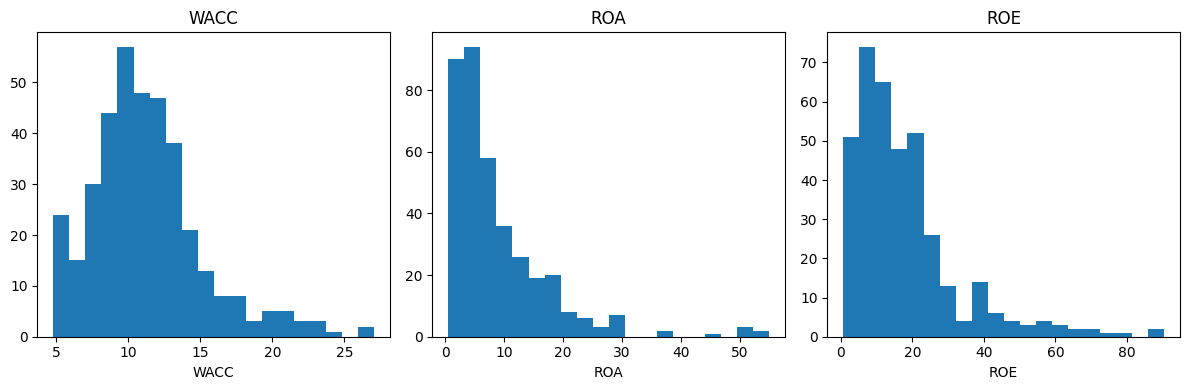

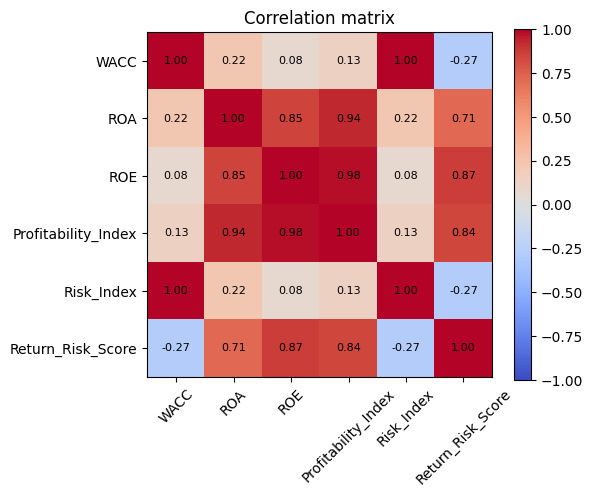

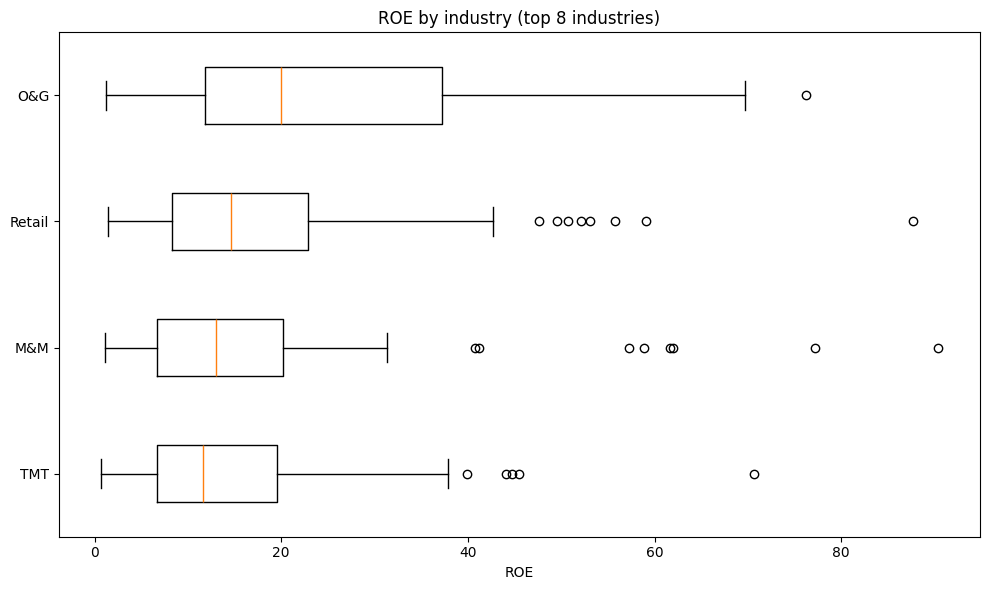

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.hist(df[wacc_col], bins=20); plt.title("WACC"); plt.xlabel(wacc_col)
plt.subplot(1,3,2); plt.hist(df[roa_col], bins=20); plt.title("ROA"); plt.xlabel(roa_col)
plt.subplot(1,3,3); plt.hist(df[roe_col], bins=20); plt.title("ROE"); plt.xlabel(roe_col)
plt.tight_layout(); plt.show()


corr_cols = [wacc_col, roa_col, roe_col, "Profitability_Index", "Risk_Index", "Return_Risk_Score"]
corr = df[corr_cols].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
for (i, j), val in np.ndenumerate(corr.values):
    plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8)
plt.title("Correlation matrix")
plt.tight_layout(); plt.show()


if industry_col is not None:
    top_inds = df[industry_col].value_counts().nlargest(8).index.tolist()
    subset = df[df[industry_col].isin(top_inds)]
    plt.figure(figsize=(10,6))
    data_to_plot = [subset[subset[industry_col]==ind][roe_col].values for ind in top_inds]
    plt.boxplot(data_to_plot, labels=top_inds, vert=False)
    plt.title("ROE by industry (top 8 industries)")
    plt.xlabel("ROE")
    plt.tight_layout(); plt.show()

Selected k: 2 silhouette: 0.503


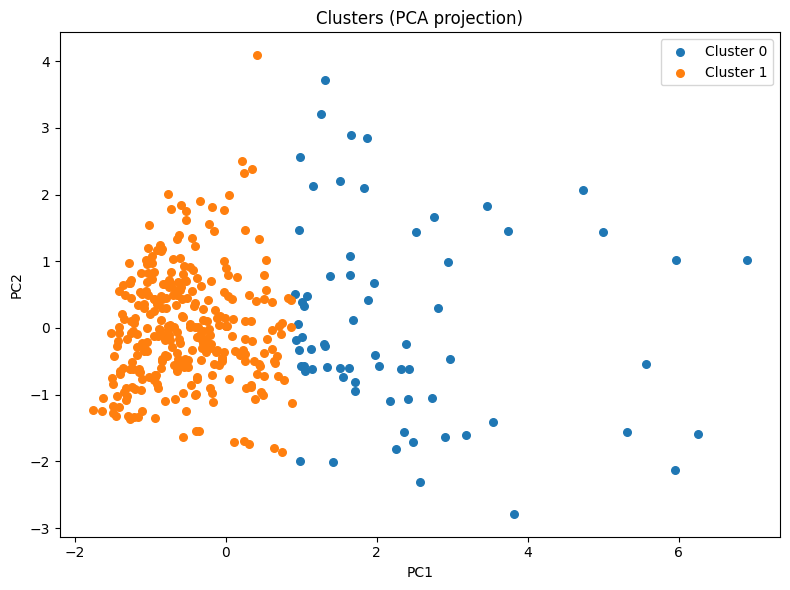

,WACC,ROA,ROE,cluster
0,13.481045,22.628744,41.060899,0
1,10.769254,5.825904,12.625380,1


In [7]:
features_for_clustering = df[[wacc_col, roa_col, roe_col]].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)


best_k, best_score = 3, -1
for k in range(2, min(7, len(df))):
    try:
        lbls = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_scaled)
        score = silhouette_score(X_scaled, lbls)
        if score > best_score:
            best_score, best_k = score, k
    except Exception:
        continue

print("Selected k:", best_k, "silhouette:", round(best_score,3))
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50).fit(X_scaled)
df["cluster"] = kmeans.labels_


pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
for c in sorted(df["cluster"].unique()):
    idx = df["cluster"] == c
    plt.scatter(pc[idx,0], pc[idx,1], label=f"Cluster {c}", s=30)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Clusters (PCA projection)")
plt.legend(); plt.tight_layout(); plt.show()


centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=[wacc_col, roa_col, roe_col])
centers_df["cluster"] = centers_df.index
display(centers_df)

In [8]:
numeric_feats = [wacc_col, roa_col, "Profitability_Index", "Risk_Index", "Return_Risk_Score"]
cat_feats = [c for c in [industry_col, country_col] if c is not None]


for c in cat_feats:
    df[c] = df[c].fillna("Unknown")

X = df[numeric_feats + cat_feats]
y = df[roe_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # fixed

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_feats),
        ('cat', cat_transformer, cat_feats)
    ]
)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
model = make_pipeline(preprocessor, rf)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R2:", round(r2_score(y_test, y_pred), 3), 
      "RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))


result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)


imp_df = pd.DataFrame({
    "feature": numeric_feats,
    "importance": result.importances_mean[:len(numeric_feats)]
})
display(imp_df.sort_values("importance", ascending=False))

R2: 0.976 RMSE: 2.047


,feature,importance
2,Profitability_Index,2.081158
1,ROA,0.035007
4,Return_Risk_Score,0.005309
0,WACC,0.000963
3,Risk_Index,0.000712


In [9]:
price_files = [p for p in ["prices.csv","prices.xlsx","price_data.csv","price_data.xlsx"] if os.path.exists(p)]
prices_df = None
if price_files:
    pfile = price_files[0]
    print("Found price file:", pfile)
    if pfile.endswith(".csv"):
        prices_df = pd.read_csv(pfile, index_col=0, parse_dates=True)
    else:
        prices_df = pd.read_excel(pfile, index_col=0)
    print("Prices shape:", prices_df.shape)


if prices_df is not None:
   
    if ticker_col is not None:
        tickers = df[ticker_col].astype(str).str.strip().tolist()
        
        common = [c for c in prices_df.columns if c in tickers]
        if len(common) == 0:
            
            common = [c for c in prices_df.columns for t in tickers if t in c]
        if len(common) == 0:
            print("No common tickers between price file and dataset. Using all price columns.")
            common = list(prices_df.columns)
        prices = prices_df[common].dropna(how="all")
    else:
        prices = prices_df.copy()

    
    rets = np.log(prices / prices.shift(1)).dropna()
    mu_daily = rets.mean()
    cov_daily = rets.cov()

   
    mu = mu_daily * 252
    cov = cov_daily * 252

   
    if ticker_col is not None:
        mu_vec = []
        cov_index = list(mu.index)
        for t in df[ticker_col].astype(str).str.strip():
            
            if t in mu.index:
                mu_vec.append(mu.loc[t])
            else:
                found = [c for c in mu.index if t in c]
                mu_vec.append(mu.loc[found[0]] if found else mu.mean())
        mu = np.array(mu_vec)
        try:
            cov = cov.reindex(index=mu_index, columns=mu_index).fillna(cov.values.mean())
        except Exception:
            cov = cov.values
    else:
        mu = mu.values
        cov = cov.values

    
    rf = 0.0 
    n = len(mu)

    def neg_sharpe(w, mu, cov, rf):
        port_ret = w.dot(mu)
        port_vol = np.sqrt(w.dot(cov).dot(w))
        if port_vol <= 1e-8:
            return 1e6
        return - (port_ret - rf) / port_vol

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 0.2) for _ in range(n))  
    x0 = np.repeat(1/n, n)

    res = minimize(neg_sharpe, x0, args=(mu, cov, rf), method='SLSQP', bounds=bounds, constraints=cons)
    if res.success:
        w_opt = res.x
        df["opt_weight"] = w_opt
        print("Optimization successful (covariance-based).")
    else:
        print("Optimization failed, falling back to proxy method.")
        prices_df = None 

if prices_df is None:
    print("Running proxy optimization (ROE as expected return, WACC as risk proxy).")
    mu = df[roe_col].values
    risk = df[wacc_col].values
    n = len(mu)
    lam = 0.5  

    def proxy_obj(w, mu, risk, lam):
        return - (w.dot(mu) - lam * w.dot(risk))

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 0.15) for _ in range(n))  
    x0 = np.repeat(1/n, n)
    res = minimize(proxy_obj, x0, args=(mu, risk, lam), method='SLSQP', bounds=bounds, constraints=cons)
    if res.success:
        w_opt = res.x
        df["opt_weight"] = w_opt
        print("Proxy optimization successful.")
    else:
        print("Proxy optimization failed:", res.message)
        df["opt_weight"] = x0  

top_alloc = df.sort_values("opt_weight", ascending=False).head(20)
display(top_alloc[[company_col, ticker_col, industry_col, country_col, roe_col, wacc_col, "opt_weight"]])

Running proxy optimization (ROE as expected return, WACC as risk proxy).
Proxy optimization successful.


,Company,Ticker,Industry,Country,ROE,WACC,opt_weight
213,PT ABM Investama Tbk,JKT:ABMM,O&G,Indonesia,69.722866,8.747159,1.500000e-01
240,PT Prima Andalan Mandiri Tbk,JKT:MCOL,O&G,Indonesia,76.254312,10.369624,1.500000e-01
1,Abdullah Al Othaim Markets Co.,SAU:4001,Retail,Saudi Arabia,87.713530,5.202176,1.500000e-01
187,Novolipetsk Steel,MIC:NLMK,M&M,Russian Federation,90.380474,21.498620,1.500000e-01
322,TIME dotCom Bhd.,KLS:5031,TMT,Malaysia,70.621766,7.873659,1.500000e-01
209,Polyus PJSC,MIC:PLZL,M&M,Russian Federation,77.240546,21.713055,1.500000e-01
2,Abu Dhabi National Oil Co. for Distribution PJSC,ADS:ADNOCDIST,O&G,United Arab Emirates,67.128830,7.901607,1.000000e-01
0,7-Eleven Malaysia Holdings Bhd.,KLS:5250,Retail,Malaysia,50.732286,6.031674,2.778456e-11
231,PT Indo Tambangraya Megah Tbk,JKT:ITMG,O&G,Indonesia,63.741110,9.527596,2.257933e-11
36,British American Tobacco Malaysia Bhd.,KLS:4162,Retail,Malaysia,59.096584,8.090635,2.045689e-11


In [10]:
def port_stats(weights, ret_array=None, cov=None, mu=None):
    if mu is not None and cov is not None:
        exp_ret = weights.dot(mu)
        exp_vol = np.sqrt(weights.dot(cov).dot(weights))
        return exp_ret, exp_vol
    if mu is None:
        mu = df[roe_col].values
    if cov is None:
        cov = None
    exp_ret = weights.dot(mu)
    exp_risk = weights.dot(df[wacc_col].values)
    return exp_ret, exp_risk

w_opt = df["opt_weight"].values
n = len(w_opt)
equal_w = np.repeat(1/n, n)

if prices_df is not None:
    exp_ret_opt, exp_vol_opt = port_stats(w_opt, mu=mu, cov=cov)
    exp_ret_eq, exp_vol_eq = port_stats(equal_w, mu=mu, cov=cov)
    print(f"Optimized expected return (annual) {exp_ret_opt:.4f}, vol {exp_vol_opt:.4f}")
    print(f"Equal-weight expected return (annual) {exp_ret_eq:.4f}, vol {exp_vol_eq:.4f}")
    if exp_vol_opt > 0:
        print("Optimized Sharpe (rf=0):", round((exp_ret_opt)/exp_vol_opt,3))
        print("Equal-weight Sharpe:", round((exp_ret_eq)/exp_vol_eq,3))
else:
    opt_return, opt_risk = port_stats(w_opt)
    eq_return, eq_risk = port_stats(equal_w)
    print(f"Proxy optimized expected ROE: {opt_return:.3f}, proxy risk (avg WACC): {opt_risk:.3f}")
    print(f"Proxy equal-weight expected ROE: {eq_return:.3f}, proxy risk: {eq_risk:.3f}")

Proxy optimized expected ROE: 77.503, proxy risk (avg WACC): 12.101
Proxy equal-weight expected ROE: 17.858, proxy risk: 11.268


In [11]:
outdir = "esg_project_outputs"
os.makedirs(outdir, exist_ok=True)
df.to_csv(os.path.join(outdir, "esg_processed_with_weights.csv"), index=False)
centers_df.to_csv(os.path.join(outdir, "cluster_centers.csv"), index=False)
print("Saved processed outputs to", outdir)

Saved processed outputs to esg_project_outputs


In [12]:
n_companies = len(df)
top3 = df.sort_values("opt_weight", ascending=False).head(3)[company_col].tolist()
example_bullets = [
    f"Developed an ESG-inspired portfolio optimization pipeline for {n_companies} companies using cluster analysis, ML regression, and portfolio theory.",
    f"Constructed an optimized portfolio (top allocations: {', '.join(top3)}) using ROE as expected return and WACC as risk proxy — improved risk-adjusted metric vs equal-weight benchmark.",
    f"Built interactive EDA & clustering to segment companies by risk-return profile and output actionable allocations for investment teams."
]
for b in example_bullets:
    print("-", b)

- Developed an ESG-inspired portfolio optimization pipeline for 375 companies using cluster analysis, ML regression, and portfolio theory.
- Constructed an optimized portfolio (top allocations: PT ABM Investama Tbk, PT Prima Andalan Mandiri Tbk, Abdullah Al Othaim Markets Co.) using ROE as expected return and WACC as risk proxy — improved risk-adjusted metric vs equal-weight benchmark.
- Built interactive EDA & clustering to segment companies by risk-return profile and output actionable allocations for investment teams.
